## Analyze model predictions from latent code using PCA, tSNE, and UMAP
---
*Last edited 15 Dec 2025 by K. Wolcott*

In [1]:
# Read in data from latent codes for training attempt
import os, re, json, torch, numpy as np, pandas as pd
from NSM.helper_funcs import NumpyTransform, pv_to_o3d, load_config, load_model_and_latents, parse_labels_from_filepaths

# Specify training directory that contains config.json, latent_codes/, and model/
train_dir = 'run_v44' # TO DO: Update to relevant training attempt directory
if train_dir not in os.getcwd():
    os.chdir(train_dir)
CKPT = '2000' # TO DO: Choose the ckpt value you want to analyze results for
LC_PATH = 'latent_codes' + '/' + CKPT + '.pth'
MODEL_PATH = 'model' + '/' + CKPT + '.pth'

# Load config
config = load_config(config_path='model_params_config.json')
device = config.get("device", "cuda:0")
train_paths = config['list_mesh_paths']
all_vtk_files = [os.path.basename(f) for f in train_paths]

# Get training paths from config
train_paths = config['list_mesh_paths']
all_vtk_files = [os.path.basename(f) for f in train_paths]

# Load model and latent codes
model, latent_ckpt, latent_codes = load_model_and_latents(MODEL_PATH, LC_PATH, config, device)

# Parse species and vertebra info from filenames (e.g. "H-capensis-22-L8.ply_align.vtk").
labels, unmatched_files = parse_labels_from_filepaths(all_vtk_files, show_debug=False)

schedulefree not found, skipping import
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loaded config from model_params_config.json
Extracted labels for 1959 out of 1959 files.


## Statistical analysis of model performance - PCA, tSNE, UMAP
---

In [ ]:
# Define functions for plotting
from sklearn.decomposition import PCA
from collections import defaultdict
import matplotlib.pyplot as plt
from NSM.helper_funcs import vertebra_sort_key
from NSM.plotting import family_info, get_family, life_history_info, get_life_history_marker, make_species_cmap, plot_family_cmap, plot_species_cmap
from NSM.plotting import calculate_region_percentages, calculate_average_percentages, plot_species_groups

# Plot the family colormap legend
#plot_family_cmap(family_info)

# Plot the species colors
#plot_species_cmap(species_colors)

### PCA

In [ ]:
# Set PC index
PC_idx = 0

# PCA for dimensionality reduction (using PC1 for y-axis)
pca = PCA()
pca_coords = pca.fit_transform(latent_codes)

# Group vertebrae numbers by species and track the maximum vertebra number per species
species_groups = defaultdict(list)
max_vertebra_numbers = defaultdict(int)

# Store vertebrae numbers and PC1 for each species
for i, (species, vertebra) in enumerate(labels):
    if species is not None and vertebra is not None:
        vertebra_label = vertebra  # Use the full vertebra label (e.g., C4, T1, L2)
        # Store vertebra label and PC1 value for sorting
        species_groups[species].append((vertebra_label, pca_coords[i, PC_idx]))
        # Update the maximum vertebra number for normalization
        if vertebra_sort_key((vertebra_label,)) < vertebra_sort_key((max_vertebra_numbers.get(species, vertebra_label),)):
            max_vertebra_numbers[species] = vertebra_label

# Normalize vertebra numbers to be a percentage of their order within each species (max vertebra index)
normalized_species_groups = defaultdict(list)
for species, points in species_groups.items():
    marker = get_life_history_marker(species)
    # Sort vertebrae within each species by region and position
    points_sorted = sorted(points, key=vertebra_sort_key)
    # Reindex vertebra labels based on their position in the sorted list
    vertebra_labels, pc1_vals = zip(*points_sorted)
    # Normalize based on the position of vertebra in the list
    for idx, (vertebra_label, pc1_val) in enumerate(points_sorted):
        # Normalize by position index (this is 0-based, so add 1 to get percentage)
        normalized_vertebra = (idx + 1) / len(vertebra_labels)  # Normalize based on the order
        normalized_species_groups[species].append((species, vertebra_label, normalized_vertebra, pc1_val, marker)) 

# Create a colormap for unique families
families = sorted({get_family(sp) for sp in normalized_species_groups.keys()})

# Add mapping for species colors based on family (gradient of light to dark)
species_colors = make_species_cmap(family_info, normalized_species_groups)

Saving figure to:  run_v44_pca_pc1_vs_normalized_vertebra_all_species.png


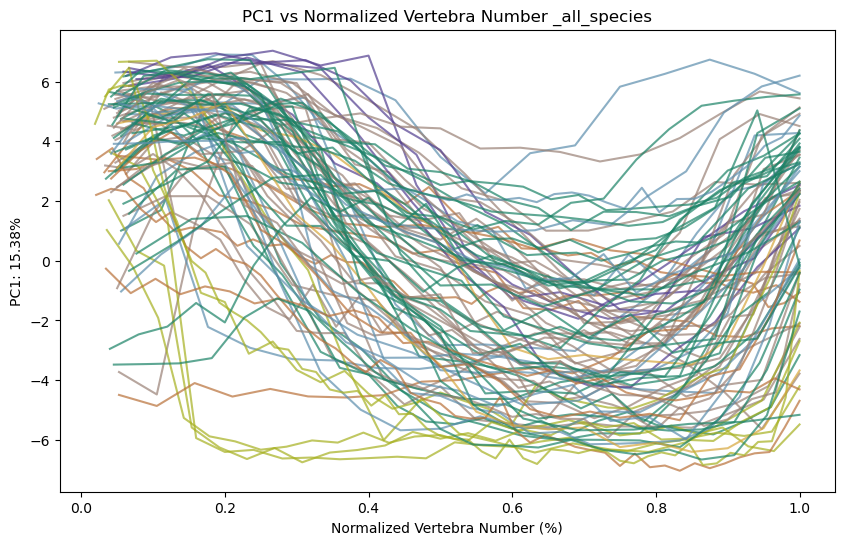

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [56]:
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species", transform_pc1=None, show_legend=False)

Saving figure to:  run_v44_pca_pc1_vs_normalized_vertebra_all_species-offset.png


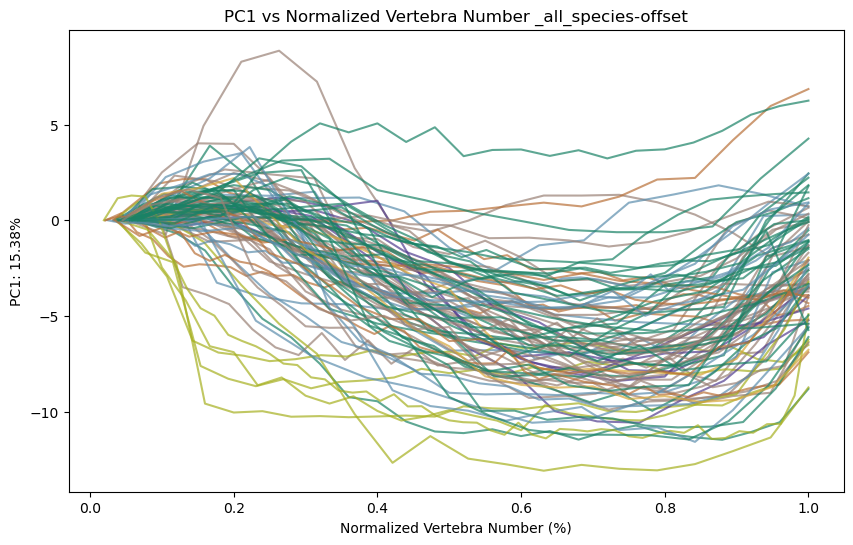

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species-offset'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [55]:
transform_pc1 = lambda ys: [y - ys[0] for y in ys] if ys else [] # Offset so all start at 0
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species-offset", transform_pc1=transform_pc1, show_legend=False)

invalid value encountered in divide


Saving figure to:  run_v44_pca_pc1_vs_normalized_vertebra_all_species-avg-std.png


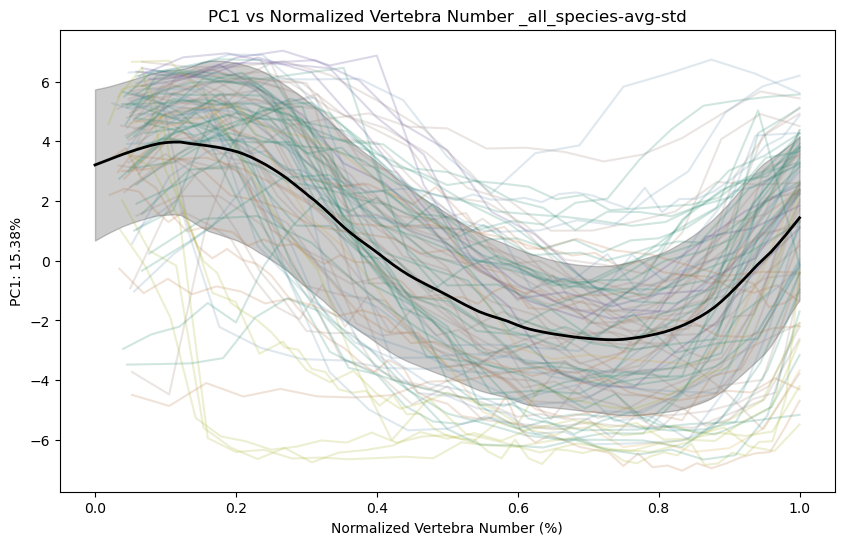

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species-avg-std'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [65]:
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species-avg-std", show_legend=False, plt_avg_std=True)

In [ ]:
# Calculate region percentages for each species
region_percentages = calculate_region_percentages(species_groups)

# Print the results
for species, counts in region_percentages.items():
    print(f"Species: {species}")
    print(f"  Cervical count: {counts['cervical_count']}, Cervical percentage: {counts['cervical_percentage']:.2f}%")
    print(f"  Thoracic count: {counts['thoracic_count']}, Thoracic percentage: {counts['thoracic_percentage']:.2f}%")
    print(f"  Lumbar count: {counts['lumbar_count']}, Lumbar percentage: {counts['lumbar_percentage']:.2f}%")
    print()

# Calculate the average percentages for Cervical, Thoracic, and Lumbar regions
avg_cervical, avg_thoracic, avg_lumbar, avg_total_vert = calculate_average_percentages(region_percentages)

# Print the results
print(f"Average Total Vertebra per spinal column: {int(avg_total_vert)} vertebrae")
print(f"Average Cervical Percentage: {avg_cervical:.2f}%")
print(f"Average Thoracic Percentage: {avg_thoracic:.2f}%")
print(f"Average Lumbar Percentage: {avg_lumbar:.2f}%")

Average Total Vertebra per spinal column: 98 vertebrae
Average Cervical Percentage: 18.04%
Average Thoracic Percentage: 35.10%
Average Lumbar Percentage: 45.81%


Mean of empty slice


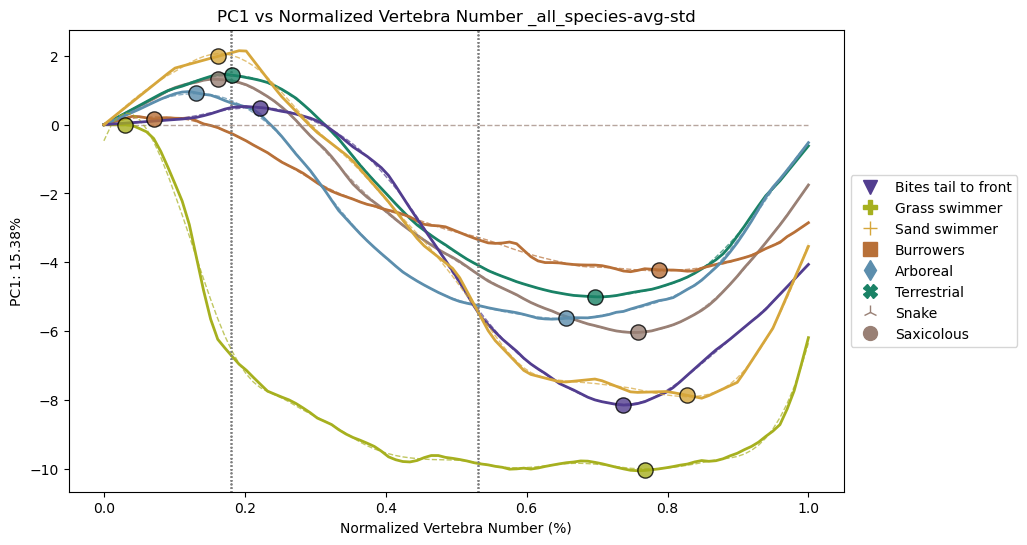

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species-avg-std'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [ ]:
transform_pc1 = lambda ys: [y - ys[0] for y in ys] if ys else [] # Offset so all start at 0
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species-avg-std", 
                     transform_pc1=transform_pc1, show_legend=True, group_by_life_hist=True, peaks_and_valleys=True, 
                     show_region_boundaries=True, avg_thoracic=avg_thoracic, avg_cervical=avg_cervical)

Mean of empty slice


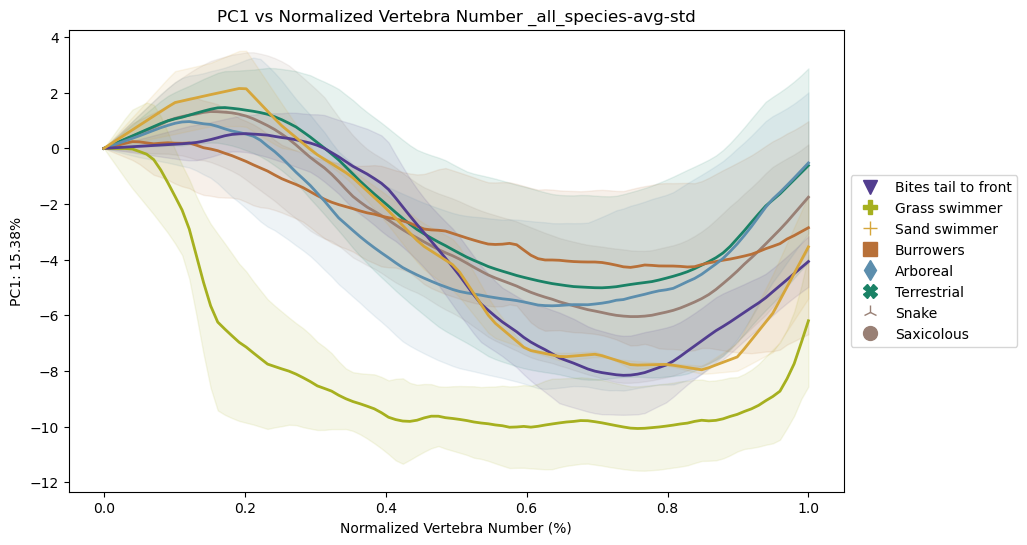

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species-avg-std'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [ ]:
transform_pc1 = lambda ys: [y - ys[0] for y in ys] if ys else [] # Offset so all start at 0
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species-avg-std", 
                     transform_pc1=transform_pc1, show_legend=True, group_by_life_hist=True, plt_std=True)

invalid value encountered in divide
Mean of empty slice
Degrees of freedom <= 0 for slice.


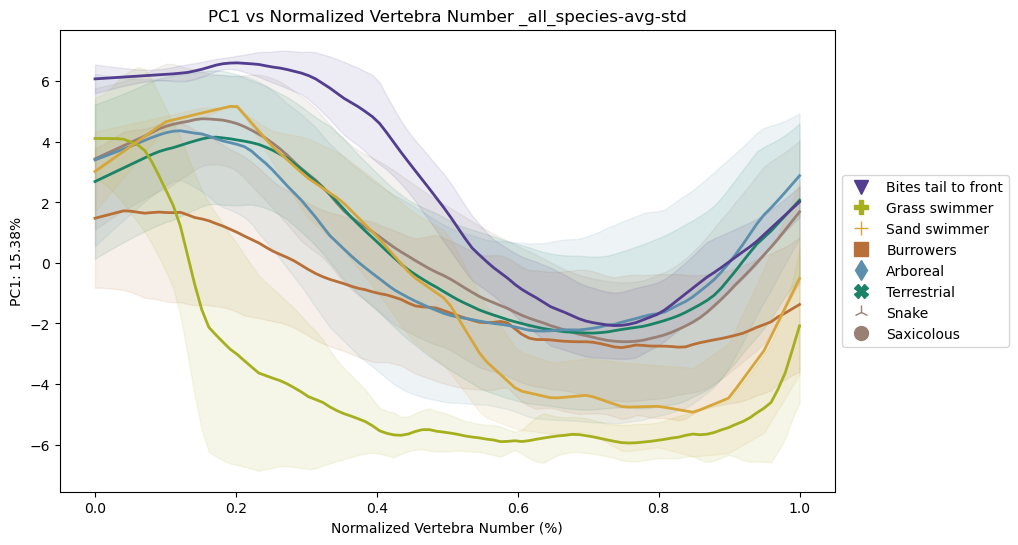

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'PC1 vs Normalized Vertebra Number _all_species-avg-std'}, xlabel='Normalized Vertebra Number (%)', ylabel='PC1: 15.38%'>)

In [126]:
transform_pc1 = lambda ys: [y - ys[0] for y in ys] if ys else [] # Offset so all start at 0
plot_species_groups(normalized_species_groups, pca, PC_idx=0, life_history_info=life_history_info, species_colors=species_colors,
                     out_prefix=os.path.split(os.getcwd())[1], suffix="_all_species-avg-std", 
                     transform_pc1=None, show_legend=True, group_by_life_hist=True, plt_std=True)